In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import gmm_experiments_lib as gmm_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
import torch

In [4]:
np.random.seed(452234)
_ = torch.manual_seed(452234)

# Draw data

In [5]:
mu0 = torch.Tensor([0, 0])
sigma0 = 3.
n_clusters = 10

n_obs = 200

In [6]:
gmm_experiment = gmm_lib.GMMExperiments(n_obs, mu0, sigma0, n_clusters, hidden_dim=200)

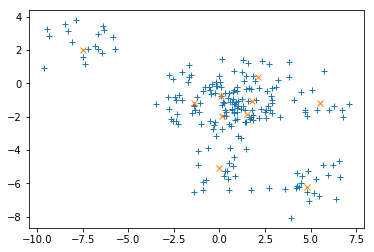

In [7]:
plt.plot(gmm_experiment.y[:, 0].numpy(), gmm_experiment.y[:, 1].numpy(), '+')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), gmm_experiment.true_mus[:, 1].numpy(), 'x')

# Set up marginalization class and run k-means init

In [8]:
gmm_experiment.set_kmeans_init_var_params()
# obj_class_reinforce.experiment_class.set_random_var_params()

k_means_init_params = deepcopy(gmm_experiment.var_params)

In [9]:
# check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = torch.exp(gmm_experiment.get_log_q().detach())

z_ind = np.argmax(class_weights.numpy(), axis = 1)

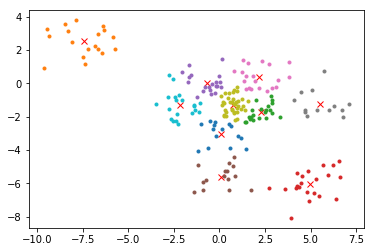

In [10]:
plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


# Train with true gradient

In [11]:
# vb_params_opt, loss_array_true_grad = obj_class_reinforce.run_SGD(alpha=0.0, topk = 1, lr = 1e-2, n_steps=1000, 
#                                                use_true_grad = True)

n_steps = 1000
lr = 1e-2

loss_array_true_grad, opt_param = pm_lib.run_SGD(get_loss = gmm_experiment.get_full_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps)

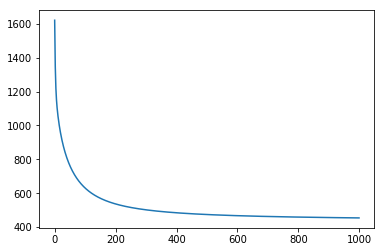

In [12]:
plt.plot(loss_array_true_grad)

In [13]:
print('initial elbo: ', loss_array_true_grad[0])

initial elbo:  1620.7862548828125


In [14]:
print('final elbo: ', loss_array_true_grad[-1])

final elbo:  454.16583251953125


In [15]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

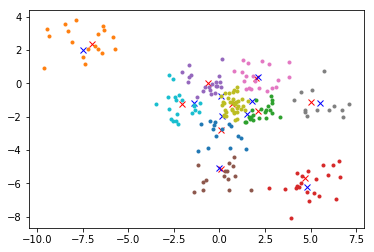

In [16]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

# Is REINFORCE useful at all here?

In [17]:
# Reuse same kmeans init
gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

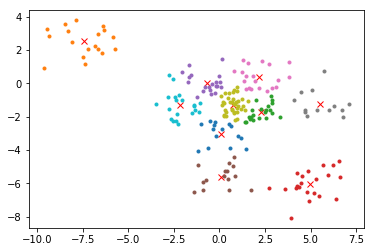

In [18]:
# # check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))

z_ind = np.argmax(class_weights.numpy(), axis = 1)

plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


In [19]:
class GMMLossClass(object): 
    def __init__(self, gmm_experiment, alpha, topk, use_baseline): 
        self.gmm_experiment = gmm_experiment
        self.alpha = alpha
        self.topk = topk
        self.use_baseline = use_baseline

    def get_loss(self): 
        return self.gmm_experiment.get_pm_loss(alpha=self.alpha, 
                                           topk=self.topk, 
                                           use_baseline=self.use_baseline)


In [20]:
gmm_loss_class = GMMLossClass(gmm_experiment, alpha = 0.0, topk = 0, use_baseline = True)

loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                get_loss = gmm_loss_class.get_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps, 
                get_full_loss = gmm_experiment.get_full_loss)

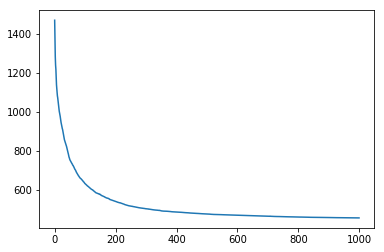

In [21]:
plt.plot(loss_array_reinforce_bl)

In [22]:
print('initial elbo: ', loss_array_reinforce_bl[0])

initial elbo:  1470.0965576171875


In [23]:
print('final elbo: ', loss_array_reinforce_bl[-1])

final elbo:  454.3670654296875


In [24]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

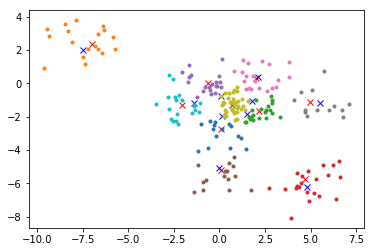

In [25]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

In [26]:
n_steps = 200
losses_array_all = np.zeros((n_clusters + 1, n_steps))

for i in range(n_clusters + 1): 
    gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

    gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
    gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

    print('topk: ', i)
    gmm_loss_class = GMMLossClass(gmm_experiment, alpha = 0.0, topk = i, use_baseline = True)

    loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                    get_loss = gmm_loss_class.get_loss, 
                    params = gmm_experiment.var_params,
                    lr = lr, 
                    n_steps = n_steps, 
                    get_full_loss = gmm_experiment.get_full_loss)
    
    losses_array_all[i, :] = loss_array_reinforce_bl
    
    print('initial elbo: ', loss_array_reinforce_bl[0])
    print('final elbo: ', loss_array_reinforce_bl[-1])

topk:  0
initial elbo:  1493.6920166015625
final elbo:  542.9507446289062
topk:  1
initial elbo:  1473.375
final elbo:  538.0452270507812
topk:  2
initial elbo:  1460.2803955078125
final elbo:  536.0542602539062
topk:  3
initial elbo:  1474.09619140625
final elbo:  536.6861572265625
topk:  4
initial elbo:  1469.16357421875
final elbo:  537.207763671875
topk:  5
initial elbo:  1461.2579345703125
final elbo:  536.8883056640625
topk:  6
initial elbo:  1455.73876953125
final elbo:  535.5594482421875
topk:  7
initial elbo:  1462.907958984375
final elbo:  536.7035522460938
topk:  8
initial elbo:  1465.184326171875
final elbo:  536.5311279296875
topk:  9
initial elbo:  1458.8629150390625
final elbo:  536.7354125976562
topk:  10
initial elbo:  1460.4385986328125
final elbo:  536.6090087890625


In [27]:
losses_array_all.shape

(11, 200)

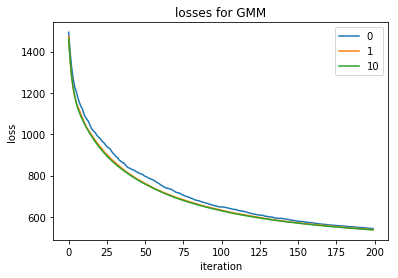

In [29]:
plt.plot(losses_array_all.T[:, np.array([0, 1, 10])], '-')

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('losses for GMM')

plt.legend(('0', '1', '10'))
